# school v.3

In [1]:
%env CUDA_VISIBLE_DEVICES=4,5

%env TRANSFORMERS_CACHE=/mnt/LLM/hub
%env OMP_NUM_THREADS=16 
%env MKL_NUM_THREADS=16 

%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

import torch
import transformers
import peft
import time
import accelerate
from tqdm.auto import trange, tqdm
import numpy as np
from matplotlib import pyplot as plt


device = device0 = torch.device('cuda:0')
device1 = torch.device('cuda:1') if torch.cuda.device_count() > 1 else device0

## Args / params

In [49]:
# MODEL_NAME_0 = 'meta-llama/Llama-2-13b-hf'  # Teacher model  - NOT USED
# MODEL_NAME_1 = 'meta-llama/Llama-2-13b-hf'   # Student model
MODEL_NAME_1 = 'meta-llama/Llama-2-70b-hf'   # Student model
torch_dtype=torch.bfloat16

EXP_NAME = 'exp_0'

class args:
    batch_size = 16
    per_device_train_batch_size = 4
    lr = 1e-4
    max_grad_norm = 0.3  # gradient clipping

### Models & tokenizer

In [ ]:
model = load_model(MODEL_NAME_1, torch_dtype=torch.bfloat16, device_map='balanced', ).eval()

# uncomment for baseline eval
for p in model.parameters():
    p.requires_grad = False

In [5]:
# from https://huggingface.co/timdettmers/guanaco-65b/blob/main/adapter_config.json
guanaco_gpeft_config = peft.LoraConfig(
    bias = "none",
    fan_in_fan_out = False,
    inference_mode=False,
    init_lora_weights = True,
    lora_alpha = 16.0,
    lora_dropout = 0.05,  # set to 0 for OF test
    modules_to_save = None,
    peft_type = "LORA",
    r = 64,
    target_modules=['q_proj', 'o_proj', 'gate_proj', 'down_proj', 'k_proj', 'up_proj', 'v_proj'],
    task_type="CAUSAL_LM",
)

In [21]:
%time model = peft.get_peft_model(model, guanaco_gpeft_config)

CPU times: user 1min 49s, sys: 1.15 s, total: 1min 51s
Wall time: 9.73 s


In [40]:
# view model layers params
for n, p in model.named_parameters():
    if 'layers.0' in n:
        print(f"{n.replace('base_model.model.', ''):<56} {str(tuple(p.shape)):<14}"
              f"{str(p.dtype).strip('torch.'):<12} {str(p.requires_grad):<6} {p.device}")

model.layers.0.self_attn.q_proj.weight                   (8192, 8192)  bfloat16     False  cuda:0
model.layers.0.self_attn.q_proj.lora_A.default.weight    (64, 8192)    float32      True   cuda:0
model.layers.0.self_attn.q_proj.lora_B.default.weight    (8192, 64)    float32      True   cuda:0
model.layers.0.self_attn.k_proj.weight                   (1024, 8192)  bfloat16     False  cuda:0
model.layers.0.self_attn.k_proj.lora_A.default.weight    (64, 8192)    float32      True   cuda:0
model.layers.0.self_attn.k_proj.lora_B.default.weight    (1024, 64)    float32      True   cuda:0
model.layers.0.self_attn.v_proj.weight                   (1024, 8192)  bfloat16     False  cuda:0
model.layers.0.self_attn.v_proj.lora_A.default.weight    (64, 8192)    float32      True   cuda:0
model.layers.0.self_attn.v_proj.lora_B.default.weight    (1024, 64)    float32      True   cuda:0
model.layers.0.self_attn.o_proj.weight                   (8192, 8192)  bfloat16     False  cuda:0
model.layers.0.self_

In [8]:
prefix_tokenizer, suffix_tokenizer = get_tokenizers(model.config._name_or_path)

Using pad_token, but it is not set yet.
Using pad_token, but it is not set yet.


## Prompt

In [9]:
from prompts import *

prompt_cot = get_cot_hub_prompt(raw=False)

## prepare data

In [10]:
import os, sys
from functools import partial

collate = partial(collate_cot_batch, prefix_tokenizer=prefix_tokenizer, suffix_tokenizer=suffix_tokenizer)

In [11]:
GSM8K_PATH = '/home/optimus/gsm8k/' 
sys.path.append(GSM8K_PATH)
from grade_school_math.dataset import get_examples, GSMDataset
train_examples = get_examples("train", data_path=os.path.join(GSM8K_PATH, 'grade_school_math/data'))
test_examples = get_examples("test", data_path=os.path.join(GSM8K_PATH, 'grade_school_math/data'))
# print(train_examples[4242])

7473 train examples
1319 test examples


In [12]:
# TRAIN SET
dataset_train = CoTDataset(train_examples, prompt_cot)
dataloader_train = DataLoader(dataset_train, batch_size=args.per_device_train_batch_size, shuffle=True, collate_fn=collate,)
print(f"{len(dataset_train)=}, {len(dataloader_train)=}")

len(dataset_train)=7473, len(dataloader_train)=1869


In [13]:
# for single batch OF testing
dataset_train_1 = CoTDataset(train_examples[:args.batch_size], prompt_cot)
dataloader_train_1 = DataLoader(dataset_train_1, batch_size=args.per_device_train_batch_size, shuffle=True, collate_fn=collate,)
print(f"{len(dataset_train_1)=}, {len(dataloader_train_1)=}")

len(dataset_train_1)=16, len(dataloader_train_1)=4


In [15]:
# TEST SET

dataset_test = CoTDataset(test_examples[:256], prompt_cot)
dataloader_test = DataLoader(dataset_test, batch_size=args.batch_size, shuffle=False, 
                              collate_fn=collate,
                             )
print(f"{len(dataset_test)=}, {len(dataloader_test)=}")

len(dataset_test)=256, len(dataloader_test)=16


In [16]:
for i, batch in enumerate (dataloader_train):
    batches.append(batch)
        
print(batch.keys())

print(batch['student_batch']['attention_mask'].shape,
      batch['main_inputs_attn_mask'].shape,
      batch['student_batch']['attention_mask'][:, -batch['main_inputs_length']:].shape)

dict_keys(['teacher_prefix_inputs', 'student_prefix_inputs', 'main_inputs', 'teacher_batch', 'student_batch', 'main_inputs_length', 'main_inputs_attn_mask'])
torch.Size([4, 77]) torch.Size([4, 9]) torch.Size([4, 9])


### OF to 1 batch

In [ ]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

history_1 = [] 

for ep in range (20):
    # print(f"EPOCH {ep}:")
        
    history_1.extend(train_epoch(model, opt, dataloader_train_1, args=args, device=device1))

  0%|          | 0/8 [00:00<?, ?it/s]

  0: loss=1.2435  acc=1.0000  delta_entropy=0.0340


  0%|          | 0/8 [00:00<?, ?it/s]

  0: loss=1.2044  acc=0.9286  delta_entropy=0.1692


  0%|          | 0/8 [00:00<?, ?it/s]

  0: loss=0.7646  acc=0.9333  delta_entropy=0.0308


  0%|          | 0/8 [00:00<?, ?it/s]

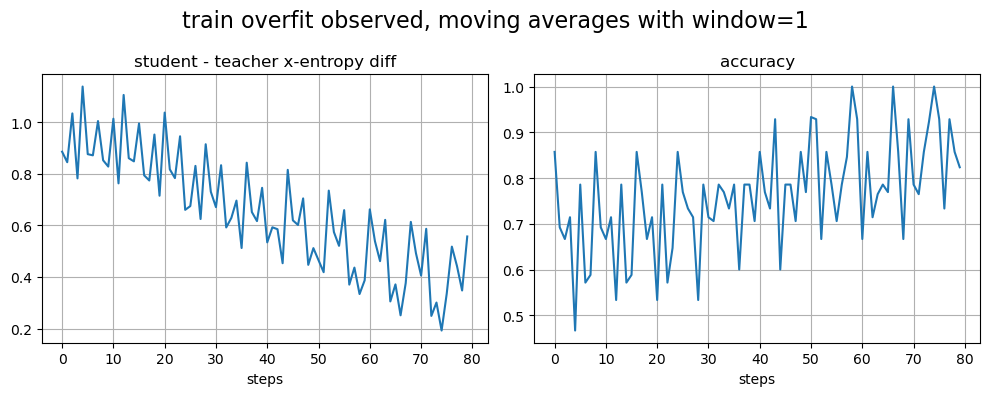

In [60]:
window = 1  # moving average window

fig, axs = plt.subplots(1, 2, figsize = (10,4))
data = [np.convolve([h['delta_entropy'] for h in history], np.ones(window), 'valid') / window,
        np.convolve([h['acc'] for h in history], np.ones(window), 'valid') / window]
titles = ('student - teacher x-entropy diff', 'accuracy')
for i, ax in enumerate(axs):
    ax.plot(data[i])
    ax.set_title(titles[i])
    ax.set_xlabel('steps')
    ax.grid()
fig.suptitle(f'train overfit observed, moving averages with {window=}', fontsize=16);
plt.tight_layout()

### Train

In [23]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [ ]:
val_logs = [validation_epoch(model, val_loader=dataloader_test, device=device)]
history = [] 
val_logs.append(validation_epoch(model, val_loader=dataloader_test, device=device))
for ep in range (3):
    print(f"EPOCH {ep}:")
        
    history.extend(train_epoch(model, opt, dataloader_train, args, device))

    to_student(model)    
    model.save_pretrained(f'peft_save/{EXP_NAME}_ep{ep}')
    
    val_logs.append(validation_epoch(model, val_loader=dataloader_test, device=device))

VALIDATION


  0%|          | 0/16 [00:00<?, ?it/s]

  0: | batch results: delta_entropy1=0.4805  acc1=0.8099
  1: | batch results: delta_entropy1=0.4565  acc1=0.8421
  2: | batch results: delta_entropy1=0.4537  acc1=0.8230
  3: | batch results: delta_entropy1=0.4824  acc1=0.8220
  4: | batch results: delta_entropy1=0.5376  acc1=0.8120
  5: | batch results: delta_entropy1=0.3729  acc1=0.8487
  6: | batch results: delta_entropy1=0.3178  acc1=0.8649
  7: | batch results: delta_entropy1=0.2658  acc1=0.9052
  8: | batch results: delta_entropy1=0.4468  acc1=0.8167
  9: | batch results: delta_entropy1=0.3909  acc1=0.7607
 10: | batch results: delta_entropy1=0.4490  acc1=0.8559
 11: | batch results: delta_entropy1=0.3711  acc1=0.8190
 12: | batch results: delta_entropy1=0.4043  acc1=0.8016
 13: | batch results: delta_entropy1=0.4218  acc1=0.8276
 14: | batch results: delta_entropy1=0.5211  acc1=0.7913
 15: | batch results: delta_entropy1=0.5267  acc1=0.8034
val results: acc=0.8250  delta_entropy=0.4312
EPOCH 1:


  0%|          | 0/1869 [00:00<?, ?it/s]

  0: loss=1.5112  acc=0.8966  delta_entropy=0.2822
 16: loss=1.1551  acc=0.7931  delta_entropy=0.3400
 32: loss=1.0193  acc=0.8750  delta_entropy=0.2134
 48: loss=1.1482  acc=0.9310  delta_entropy=0.2892
 64: loss=1.1928  acc=0.9375  delta_entropy=0.1233
 80: loss=1.4352  acc=0.8276  delta_entropy=0.3184
 96: loss=1.0683  acc=0.8929  delta_entropy=0.2654
112: loss=1.0164  acc=0.9333  delta_entropy=0.2093
128: loss=0.6521  acc=0.9143  delta_entropy=0.2692
144: loss=1.3232  acc=0.9310  delta_entropy=0.3192
160: loss=1.2563  acc=0.8846  delta_entropy=0.3282
176: loss=1.3732  acc=0.8966  delta_entropy=0.2491
192: loss=1.3764  acc=0.8214  delta_entropy=0.4552
208: loss=0.9590  acc=0.8889  delta_entropy=0.3183
224: loss=1.1930  acc=0.8667  delta_entropy=0.3658
240: loss=1.6434  acc=0.7241  delta_entropy=0.5237
256: loss=1.0383  acc=0.9643  delta_entropy=0.2679
272: loss=1.4016  acc=0.9000  delta_entropy=0.3536
288: loss=1.1821  acc=0.8438  delta_entropy=0.2627
304: loss=1.1913  acc=0.9231  d

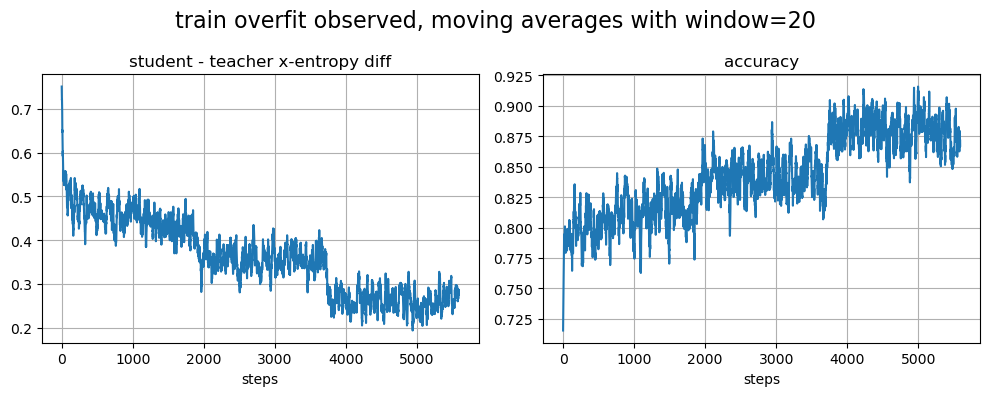

In [32]:
plot_history(history, window=20)

In [1]:
%%stop

UsageError: Cell magic `%%stop` not found.


In [35]:
model.save_pretrained(f'peft_save/{EXP_NAME}')

## Test model

In [43]:
# simple inference test
prompt = "return just words, separated by commas:\nQuestion: name 3 random birds.\nAnswer:"

result = model_inference(prompt, model=model, tokenizer=prefix_tokenizer, stop_token_id=13, num_return_sequences=3,
                        max_new_tokens=32)
print(*result, sep = '\n')

1. crows, 2. pigeons, 3. doves.
Sparrow, Robin and Hummingbird
pigeons, sparrows, seagulls.


### zero-shot no cot

In [44]:
kojima_zero_template  = "Q: {}\n" + "A: The answer is"

In [45]:
log_basic = test_gsm(
    model=model, 
    tokenizer=prefix_tokenizer, 
    template=kojima_zero_template, 
    end_of_answer_token_id = 13, 
    verbose=True, 
    max_length=32,
    num_return_sequences = 8,
    test_range = (0, 200)
)

  0%|          | 0/200 [00:00<?, ?it/s]

0: False 20.0!=18.0 c=0.5, t=2.2s, ans:[22.0, 22.0, 20.0, 16.0, 20.0, 20.0, 20.0, 22.0]
1: False 5.0!=3.0 c=0.8, t=8.2s, ans:[5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, 5.0]
2: False 95000.0!=70000.0 c=0.1, t=8.8s, ans:[135000.0, 145000.0, 95000.0, 140000.0, 170000.0, 110000.0, 165000.0, 120000.0]
3: False 3240.0!=540.0 c=0.4, t=8.1s, ans:[1380.0, 3240.0, 1800.0, 1080.0, 1260.0, 3240.0, 1260.0, 3240.0]
4: False 30.0!=20.0 c=0.5, t=9.3s, ans:[20.0, 35.0, 30.0, 50.0, 30.0, 30.0, 25.0, 30.0]
5: False 56.0!=64.0 c=0.2, t=8.1s, ans:[56.0, 60.0, 96.0, 48.0, 64.0, 76.0, 64.0, 56.0]
6: False 120.0!=260.0 c=0.5, t=8.0s, ans:[140.0, 140.0, 120.0, 100.0, 120.0, 140.0, 120.0, 120.0]
7: False 140.0!=160.0 c=0.4, t=3.8s, ans:[140.0, 140.0, 340.0, 120.0, 240.0, 130.0, 280.0, 140.0]
8: False 180.0!=45.0 c=0.2, t=2.9s, ans:[180.0, 240.0, 510.0, 120.0, 270.0, 180.0, 205.0, 270.0]
9: False 540.0!=460.0 c=0.4, t=1.9s, ans:[4.0, 480.0, 110.0, 540.0, 540.0, 450.0, 500.0, 540.0]
10: False 252.0!=366.0 c=0.4, t=1.8s,

In [46]:
score_log2(log_basic)

(0.215, 0.226875)

In [50]:
torch.save(log_basic, f"logs_save/{EXP_NAME}_nocot.pt")

In [ ]:
torch.save(log_basic, './logs_save/L2_70_zero_8_ko_log.pt')

In [47]:
template_cot_few = prompt_cot + "\nQuestion: {}\nLet's think step by step: "

log_cot_few = test_gsm(
    model=model, 
    tokenizer=prefix_tokenizer, 
    template=template_cot_few, 
    end_of_answer_token_id = 13, 
    verbose=True, 
    max_length=32,
    num_return_sequences = 8,
    test_range = (0, 200)
)

  0%|          | 0/200 [00:00<?, ?it/s]

0: True 18.0=18.0 c=0.9, t=18.7s, ans:[18.0, 9.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]
1: True 3.0=3.0 c=0.9, t=19.7s, ans:[3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0]
2: False 130000.0≠70000.0 c=0.4, t=44.2s, ans:[130000.0, 130000.0, 10000.0, 250000.0, 90000.0, 130000.0, 195000.0, 40000.0]
3: True 540.0=540.0 c=0.8, t=27.5s, ans:[540.0, 180.0, 540.0, 540.0, 540.0, 540.0, 3.0, 540.0]
4: False 10.0≠20.0 c=0.4, t=45.8s, ans:[10.0, 20.0, 10.0, 10.0, 20.0, 13.0, 7.0, 3.0]
5: False 56.0≠64.0 c=0.2, t=31.8s, ans:[5000.0, 68.0, 56.0, 24.0, 56.0, 80.0, 68.0, 128.0]
6: True 260.0=260.0 c=0.5, t=36.4s, ans:[260.0, 260.0, 200.0, 140.0, 260.0, 120.0, 500.0, 260.0]
7: False 100.0≠160.0 c=0.2, t=35.2s, ans:[100.0, 40.0, 120.0, 80.0, 250.0, 160.0, 240.0, 100.0]
8: False 20.0≠45.0 c=0.1, t=47.1s, ans:[80.0, 480.0, 270.0, 370.0, 355.0, 180.0, 144.0, 20.0]
9: True 460.0=460.0 c=0.4, t=32.0s, ans:[460.0, 510.0, 453.0, 460.0, 460.0, 2011.0, 400.0, 25.0]
10: False 186.0≠366.0 c=0.4, t=69.5s, ans:[186.0, 366.0, 

In [48]:
score_log(log_cot_few)

(0.56, 0.394375)

In [51]:
torch.save(log_cot_few, f"logs_save/{EXP_NAME}_cot_few.pt")